C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: ./debug/binary.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


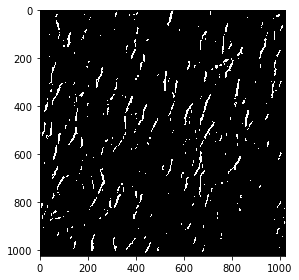

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


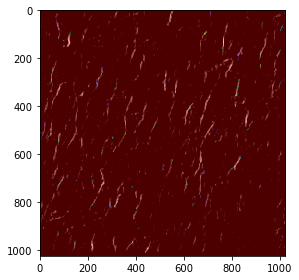

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


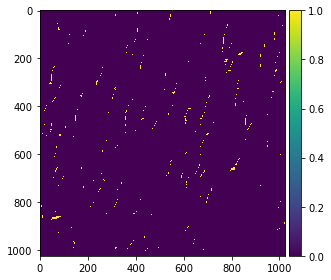

In [2]:
from skimage.morphology import binary_erosion,skeletonize,binary_dilation,binary_closing,remove_small_holes
from skimage.filters import threshold_otsu
from skimage import io
from skimage.color import rgb2gray,label2rgb
from skimage.measure import label, regionprops,approximate_polygon
from skimage.draw import line
from scipy import signal
import numpy as np
from skimage.filters import meijering
#################################################################
def findJoints(skeleimage):
    tshape1 = np.array([[0,1,0],
                        [1,1,0],
                        [0,1,0]])
    tshape2 = np.array([[1,0,1],
                        [0,1,0],
                        [1,0,0]])
    yshape1 = np.array([[1,0,1],
                        [0,1,0],
                        [0,1,0]])
    yshape2 = np.array([[0,0,1],
                        [1,1,0],
                        [0,1,0]])
    pshape1 = np.array([[0,1,0],
                        [1,1,1],
                        [0,1,0]])
    pshape2 = np.array([[1,0,1],
                        [0,1,0],
                        [1,0,1]])

    joints = [tshape1,tshape1.T,np.fliplr(tshape1),np.flipud(tshape1.T)]
    joints.extend([tshape2,np.fliplr(tshape2),np.flipud(tshape2),np.flipud(np.fliplr(tshape2))])
    joints.extend([yshape1,yshape1.T,np.flipud(yshape1),np.fliplr(yshape1.T)])
    joints.extend([yshape2,yshape2.T,np.flipud(yshape2),np.fliplr(yshape2)])
    joints.extend([pshape1,pshape2])
    
    im = np.zeros(skeleimage.shape)
    for j in joints:
        #print(j)
        im += (signal.convolve2d(skeleimage,j,mode='same')/j.sum()).astype(int)
    return im>0;
################################################################

debug_mode = True
debug_folder = './debug/'

def showLines(img):
    thresh = threshold_otsu(img)

    binary = img > thresh
    
    if debug_mode :
        io.imsave(debug_folder+"binary.jpg",binary*255)
        io.imshow(binary)
        io.show()
        
    binary = remove_small_holes(binary)
    skeleton = skeletonize(binary)

    # label image regions
    label_image = label(skeleton)
    
    if debug_mode :
        image_label_overlay = label2rgb(label_image, image=img)
        io.imsave(debug_folder+"image_label_overlay.jpg",image_label_overlay)
        io.imshow(image_label_overlay)
        io.show()
    
    prop = regionprops(label_image)
    #print(len(prop))

    mask = np.ones([3,3])
    kernel = mask<0

    
    overlay_polylineImage = np.zeros(img.shape)
    for obj in prop:
        #print(label.convex_image)
        if obj.area > 10:
            b = findJoints(obj.image)
            joints = label(b)
            dots = regionprops(joints)
            img4edit = np.copy(obj.image)
            
            #io.imshow(closing(obj.image))
            #io.show()
            min_row = obj.bbox[0]
            min_col = obj.bbox[1]
            for d in dots:
                y,x = np.array(d.centroid).astype(int)
                mask = np.copy(img4edit[y-1:y+2,x-1:x+2])

                img4edit[y-1:y+2,x-1:x+2] = 1

                branchLabel = label(img4edit)
                branches = regionprops(branchLabel)
                branchsize= [branch.area for branch in branches]
                branchcoord = [branch.coords for branch in branches]
                if len(branchsize) > 1:
                    minIndex = np.argmin(np.array(branchsize))
                    for i,j in branchcoord[minIndex]:
                        img4edit[i,j] = 0
                    img4edit[y-1:y+2,x-1:x+2]=mask
                    #img4edit[y,x]=1

            ##### to fit into polyline
            img4edit = skeletonize(binary_dilation(binary_dilation(img4edit)))

            label4coord = label(img4edit)
            coords = regionprops(label4coord)[0]
            polyline = approximate_polygon(coords.coords, tolerance=0.02)
            
            xlast=-1
            ylast=-1
            row = []
            col = []

            for i,j in polyline:
                if xlast != -1:
                    rr,cc = line(min_row+ylast,min_col+xlast,min_row+i,min_col+j)
                    row.extend(rr)
                    col.extend(cc)
                    #polylineImage[rr,cc] = 1
                xlast = j
                ylast = i    
                #polylineImage[i,j] = 1

            overlay_polylineImage[row, col] = 1  




            #io.imshow(polylineImage)
            #io.show()
    return overlay_polylineImage



if __name__ == '__main__':
    msk_img = io.imread("./test.jpg")
    msk_img = rgb2gray(msk_img)
    overlay = showLines(msk_img)
    io.imsave('overlay.jpg',overlay)
    io.imshow(overlay)

tiffimg shape: [[0.10196078 0.09803922 0.08235294 ... 0.11372549 0.08235294 0.06666667]
 [0.10196078 0.09803922 0.08235294 ... 0.11372549 0.08235294 0.06666667]
 [0.10196078 0.10196078 0.08627451 ... 0.11372549 0.08235294 0.06666667]
 ...
 [0.0627451  0.06666667 0.06666667 ... 0.1372549  0.10588235 0.09411765]
 [0.0627451  0.0627451  0.06666667 ... 0.12941176 0.09803922 0.09411765]
 [0.0627451  0.0627451  0.0627451  ... 0.1254902  0.09803922 0.08627451]]


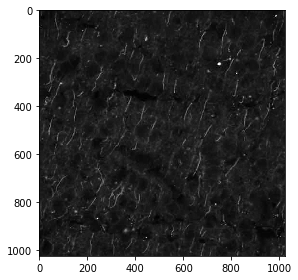

torch.Size([1, 1, 1024, 1024])
data loader: [[0.10196079 0.09803922 0.08235294 ... 0.11372549 0.08235294 0.06666667]
 [0.10196079 0.09803922 0.08235294 ... 0.11372549 0.08235294 0.06666667]
 [0.10196079 0.10196079 0.08627451 ... 0.11372549 0.08235294 0.06666667]
 ...
 [0.0627451  0.06666667 0.06666667 ... 0.13725491 0.10588235 0.09411765]
 [0.0627451  0.0627451  0.06666667 ... 0.12941177 0.09803922 0.09411765]
 [0.0627451  0.0627451  0.0627451  ... 0.1254902  0.09803922 0.08627451]]


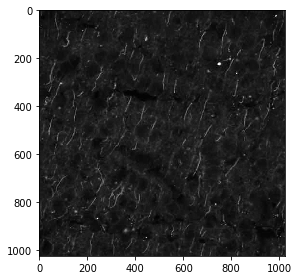

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


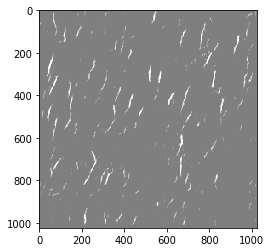

In [16]:
from binary import Net,imshow,get_path
import torch
import torchvision
from skimage import io

#########################################################
tiffimg = io.imread("./test/0/rgb.jpg")
tiffimg = tiffimg[:,:,0]
tiffimg = tiffimg/255.0
print("tiffimg shape:",tiffimg)
io.imshow(tiffimg)
io.show()
#########################################################
PATH = get_path()
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.load_state_dict(torch.load(PATH,map_location=device))

data_path = './test/'
train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=10,
        num_workers=0,
        shuffle=True
    )
# get some random training images
dataiter = iter(train_loader)
images= dataiter.next()

x = images[0][0].unsqueeze_(0)
x = torch.max(x, dim=1,keepdim = True)[0].to(device)
###########################
print(x.shape)
ximg = x.numpy().reshape([1024,1024])
print("data loader:",ximg)
io.imshow(ximg)
io.show()

ximg_torch = torch.from_numpy(tiffimg).float()
ximg_torch = ximg_torch.view([1,1,1024,1024])

###########################
#predic = net(x).detach()
predic = net(ximg_torch).detach()
imshow(torchvision.utils.make_grid(predic.cpu()))
torchvision.utils.save_image(predic,"./result.jpg")


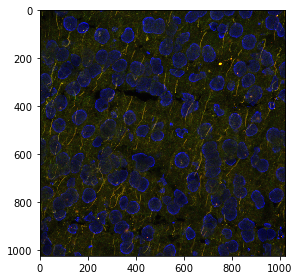

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


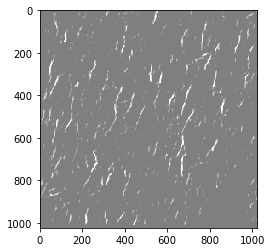

Lossy conversion from float64 to uint8. Range [0.0, 1.435293719685012]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


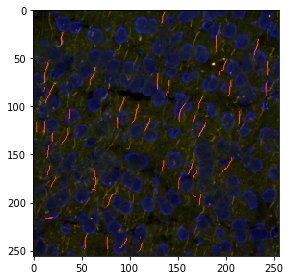

In [5]:
from binary import Net,imshow,get_path
from skeleton import showLines
import torch
import torchvision
from skimage import io,img_as_ubyte
from skimage.transform import rescale, resize, downscale_local_mean
import numpy as np

PATH = get_path()
net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
weights = torch.load(PATH,map_location=device)
net.load_state_dict(weights)

net = net.double()
tiffimg = io.imread("MAX_na1.2 ais cortex-2.tif")
rr,cc,_ =tiffimg.shape
red_img = tiffimg[:,:,2]/4095.0

#swap R & B
rgbtiff = tiffimg.copy()
rgbtiff[:,:,0] = tiffimg[:,:,2]
rgbtiff[:,:,2] = tiffimg[:,:,0]
rgbtiff = rgbtiff/4095.0
io.imshow(rgbtiff)
io.show()

red_img = torch.from_numpy(red_img)
red_img = red_img.view([1,1,rr,cc])
red_img = red_img.to(device)

msk_img = net(red_img)

msk_img = msk_img.detach()
msk_img = msk_img.cpu()
imshow(torchvision.utils.make_grid(msk_img))

msk_img = msk_img.view([rr,cc])
msk_img = msk_img.numpy()

msk_img = resize(msk_img, (msk_img.shape[0] // 4, msk_img.shape[1] // 4),
                       anti_aliasing=True)
#sav_img = np.zeros([1024,1024,3])
#sav_img[:,:,0]=msk_img
#io.imsave("./test.jpg",msk_img)
overlay = showLines(msk_img)

rgbtiff = resize(rgbtiff, (rgbtiff.shape[0] // 4, rgbtiff.shape[1] // 4),
                       anti_aliasing=True)
rgbtiff[:,:,0] = overlay+rgbtiff[:,:,0]
rgbtiff = rgbtiff.clip(0.0,1.0)
io.imshow(rgbtiff)
io.imsave('overlay.jpg',overlay)